In [37]:
from dotenv import load_dotenv
import json
import os
import requests

In [4]:
load_dotenv("../../.env")

True

In [8]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_API_KEY[:5]

'sk-aK'

In [10]:
from typing import Dict, Iterator, List, Union

In [30]:
def packaging_messages(system: str, user_input: Union[str, List[Dict[str, str]]]) -> List[Dict[str, str]]:
    role_dict = dict(
        role="system",
        content=system
    )
    if isinstance(user_input, str):
        messages = [
            role_dict,
            dict(
                role="user",
                content=user_input,
            )]
    elif isinstance(user_input, list):
        messages = [
            role_dict,
            *user_input,
        ]
    else:
        raise TypeError("user_input must be str or list")
    return messages


def packaging_payload(
    model_name,
    messages,
    **kwargs,
):
    return dict(
        model=model_name,
        messages=messages,
        **kwargs,
    )
        

In [155]:
class OpenAIChat:
    def __init__(self, model_name: str):
        self._api_key = os.getenv("OPENAI_API_KEY")
        if self._api_key is None:
            raise ValueError("No OpenAI API key found.")
        self._headers = {
            "Authorization": f"Bearer {self._api_key}",
            "Content-Type": "application/json",}
        self.api_key = self._api_key[:5] + "x" * len(self._api_key[5:])
        self.model_name = model_name

    def __repr__(self):
        return f"OpenAIChat(model_name={self.model_name!r}, api_key={self.api_key!r})"

    def parse_stream_response(
        self,
        response
    ) -> Iterator[str]:
        for chunk in response.iter_lines():
            if chunk:
                string = chunk.decode("utf-8")
                json_string = string.strip("data: ")
                if json_string == "[DONE]":
                    break
                data = json.loads(json_string)

                if "choices" in data:
                    choice = data["choices"][0]
                    delta = choice["delta"]
                    if "content" in delta:
                        yield delta["content"]

    def __call__(
        self,
        system: str,
        prompt: str,
    ) -> Iterator[str]:
        messages = packaging_messages(system, prompt)
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            json=packaging_payload(
                model_name=self.model_name,
                messages=messages,
                stream=True,
            ),
            headers=self._headers,
        )
        response.raise_for_status()
        yield from self.parse_stream_response(response)


class OpenAIJSONChat(OpenAIChat):
    def __call__(
        self,
        system: str,
        prompt: str,
    ) -> Union[dict, list]:
        messages = packaging_messages(system, prompt)
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            json=packaging_payload(
                model_name=self.model_name,
                messages=messages,
                response_format={"type": "json_object"},
            ),
            headers=self._headers,
        )
        response.raise_for_status()
        return_data = response.json()

        if "choices" in return_data:
            choice = return_data["choices"][0]
            return json.loads(choice["message"]["content"])

class GPTVisionChat(OpenAIChat):
    def __call__(
        self,
        system: str,
        prompt: str,
        image_url: str,: 
    ) -> Iterator[str]:
        

In [149]:
MODEL_NAME = "gpt-4-1106-preview"

In [150]:
chat = OpenAIChat(MODEL_NAME)
chat

OpenAIChat(model_name='gpt-4-1106-preview', api_key='sk-aKxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

In [151]:
IMAGE_SEARCH_ROLE = """
Please offer 3 key phrases that can be used for google image search,
the image results will be good at explaining the question asked by user input,
please return json in format of:
{
    "search": [
        "search phrase 1",
        "search phrase 2",
    ]
}
"""

In [152]:
test_questions = [
    "How to explain Kepler's 2nd law?",
]

In [153]:
for token in chat(IMAGE_SEARCH_ROLE, test_questions[0]):
    print(token, end="")

```json
{
    "search": [
        "Kepler's second law diagram",
        "Law of equal areas animation",
        "Kepler's laws of planetary motion infographic"
    ]
}
```

In [156]:
json_chat = OpenAIJSONChat(MODEL_NAME)

In [157]:
json_chat(IMAGE_SEARCH_ROLE, test_questions[0])

{'search': ["Kepler's second law diagram",
  'Area sweeping equal times orbits',
  'Law of equal areas animation']}

## Image Search

In [1]:
%pip install jmd_imagescraper

DEPRECATION: pytorch-lightning 1.7.3 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from jmd_imagescraper.core import *

In [13]:
from pathlib import Path

In [14]:
image_root = Path("images")
image_root.mkdir(exist_ok=True)

In [15]:
# %pip install google-api-python-client

In [18]:
from dotenv import load_dotenv

In [25]:
load_dotenv()

True

In [29]:
from googleapiclient.discovery import build
import os
from typing import List, Dict, Optional

In [91]:
def google_search(search_term, api_key, cse_id, **kwargs):
    """
    You have to manage your custom search engine at:
    https://cse.google.com/cse/all

    Say you project name is <project name>
    https://console.cloud.google.com/apis/api/customsearch.googleapis.com/metrics?project=<project name>
    
    
    """
    service = build("customsearch", "v1", developerKey=api_key)
    res = service.cse().list(q=search_term, cx=cse_id, searchType='image', **kwargs).execute()
    if "items" not in res:
        print(res)
    return list(result['link'] for result in res['items'])

api_key = os.getenv("GOOGLE_API_KEY")
cse_id = os.getenv("GOOGLE_CSE_ID")

img_links = google_search('Vancouver major tourist attractions map', api_key, cse_id, num=10)

In [92]:
import requests

In [93]:
def download_image(link: str, image_root) -> Optional[Path]:
    """
    Down load image from a link
    
    If download success, return the local path of the image
    
    If download fail, return None
    """
    image_root = Path(image_root)
    image_path = image_root / link.split("/")[-1]
    
    # in case the image is already downloaded
    if image_path.exists():
        return image_path

    res = requests.get(link)
    if res.status_code == 200:
        with open(image_path, "wb") as f:
            f.write(res.content)
        return image_path
    else:
        return None

In [94]:
from joblib import Parallel, delayed
from PIL import Image

In [95]:
local_images = Parallel(n_jobs=10, backend="threading")(
    delayed(download_image)(link, image_root) for link in img_links
)

In [96]:
local_images = list(i for i in local_images if i is not None)

In [97]:
local_images

[PosixPath('images/12-SALZBURG-AUSTRIA-Mozart-and-The-Sound-of-Music-put-Salzburg-on-the-map-Its-also-home-to-Austrias-largest-beer-hall-Brustbl-zu-Mlln-and-has-a-slew-of-museums-restaurants-and-palaces-to-discover-.jpg'),
 PosixPath('images/birkenstock-bryson-lena-casual-boots.jpg'),
 PosixPath('images/IMG%20%289%29-XL.jpg'),
 PosixPath('images/30-STOCKHOLM-SWEDEN-With-narrow-cobblestone-streets-and-a-colorful-waterfront-Stockholm-is-an-exceptionally-charming-city-Its-also-filled-with-museums-and-landmarks-that-make-it-a-prime-cultural-and-entertainment-center-within-Sweden-.jpg'),
 PosixPath('images/1498.jpg?width=1200&height=630&quality=85&auto=format&fit=crop&overlay-align=bottom%2Cleft&overlay-width=100p&overlay-base64=L2ltZy9zdGF0aWMvb3ZlcmxheXMvdGctZGVmYXVsdC5wbmc&s=2898097a9026ffeb6ac14140124cb93f'),
 PosixPath('images/12-salzburg-austria-mozart-and-the-sound-of-music-put-salzburg-on-the-map-its-also-home-to-austrias-largest-beer-hall-brustbl-zu-mlln-and-has-a-slew-of-museums-r

In [98]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import io

In [99]:
def fig2img(fig):
    """
    Convert a Matplotlib figure to a PIL Image and return it
    """
    
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def combine_images(images, ):
    """
    Combine 9 or less images into a single 512 x 512 image
    """
    images = list(images)
    titles = list(f"image {i}" for i in range(len(images)))
    
    if len(images) == 0:
        raise ValueError("images can not be empty")
    elif len(images) == 1:
        return images[0].resize((512, 512))
    else:
        if len(images) > 9:
            images = images[:9]
            titles = titles[:9]
            
        fig, axs = plt.subplots(3, 3, figsize=(9, 9), )
        for ax, image, title in zip(axs.flatten(), images, titles):
            image_arr = np.array(Image.open(image))
            ax.imshow(image_arr)
            ax.set_title(title)
            ax.axis("off")

        pil_result = Image.fromarray(np.uint8(fig2img(fig)))
        plt.close(fig)
        return pil_result
        

In [100]:
rt_img = combine_images(local_images[:9])

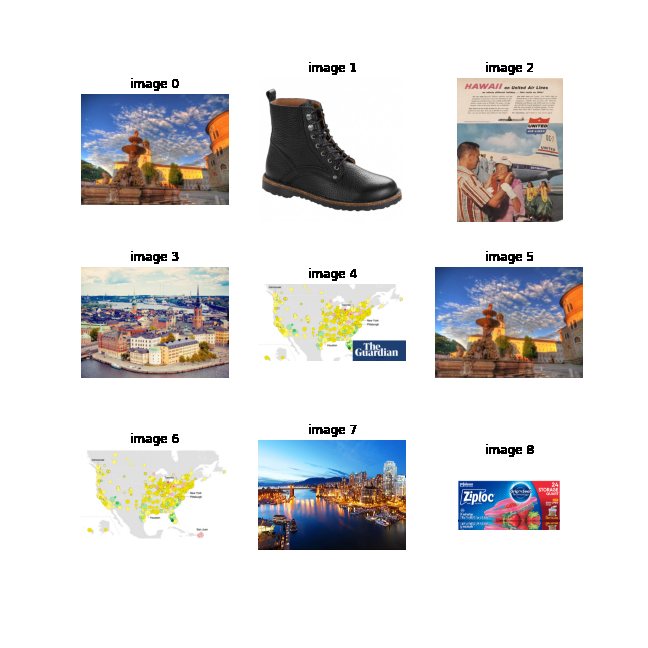

In [101]:
rt_img